# Imports and Paths

In [37]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy
import cartopy.crs as ccrs
import numba as nb
from astropy.convolution import convolve
from scipy.ndimage import maximum_filter
from scipy.spatial.distance import cdist
import scipy.stats as sts
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [38]:
from palettable.cartocolors.qualitative import Prism_8
prism = Prism_8.mpl_colors
blue = prism[1]
green = prism[3]
purple = prism[0]
red = prism[7]
orange = prism[6]
yellow = prism[5]
gray = '#303039'
#importing plotting paramet ners
style = '/home/gleung/scripts/styles/bee-paperlight.mplstyle'
#style = '/home/gleung/scripts/styles/bee-presentationtransparent.mplstyle'
plt.style.use(style)

import matplotlib.font_manager as font_manager
from matplotlib import rcParams

# Add every font at the specified location
font_dir = ['/home/gleung/scripts/futura']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

# Set font family globally
rcParams['font.family'] = 'Futura'

bg = 'white'
lcol = 'black'

from palettable.cmocean.sequential import Ice_20
cloud = mcolors.ListedColormap(Ice_20.mpl_colors)

In [3]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def add_latlon(ax):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

In [65]:
ver = 'terra'
var = 'aod'

dataPath = '/moonbow/gleung/satlcc/GFC_2021_v1.9/'
figPath = '/moonbow/gleung/satlcc-figures/deforest_effect/'
gfcPath = '/moonbow/gleung/satlcc/GFC_processing/'
gswPath = '/moonbow/gleung/satlcc/GSW_processing/'
modisPath = f'/moonbow/gleung/satlcc/MODIS_{ver}_{var}/'
anaPath = '/moonbow/gleung/satlcc/deforest_effect/'

for path in [figPath,anaPath]:
    if not os.path.isdir(path):
        os.mkdir(path)

# Calculating Inter-Annual Mean

In [70]:
if ver == 'terra':
    yrs = range(2001,2021)
elif ver == 'aqua':
    yrs = range(2003,2018)#2021)

In [71]:
alldf = pd.DataFrame()

for yr in yrs:
    print(yr)
    df = pd.read_pickle(f"{modisPath}/annual/{yr}.pkl")[['mean_count','count']]
    
    if yr == yrs[0]:
        alldf = df.copy()
    else:
        alldf = alldf.add(df, fill_value=0)

alldf['mean'] = alldf['mean_count']/alldf['count']

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


FileNotFoundError: [Errno 2] No such file or directory: '/moonbow/gleung/satlcc/MODIS_terra_aod//annual/2020.pkl'

In [73]:
alldf['mean'] = alldf['mean_count']/alldf['count']
alldf = alldf[['mean']]
alldf.to_pickle(f"{modisPath}annual_ave_2001-2020.pkl")

In [78]:
print(plot.min().min())

-0.05000000237487257


# Plotting

In [93]:
print(np.logspace(-2, 0, 7))

[0.01       0.02154435 0.04641589 0.1        0.21544347 0.46415888
 1.        ]


/home/gleung/miniconda3/envs/satlcc/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: Log scale: values of z <= 0 have been masked
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/home/gleung/miniconda3/envs/satlcc/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: Log scale: values of z <= 0 have been masked
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


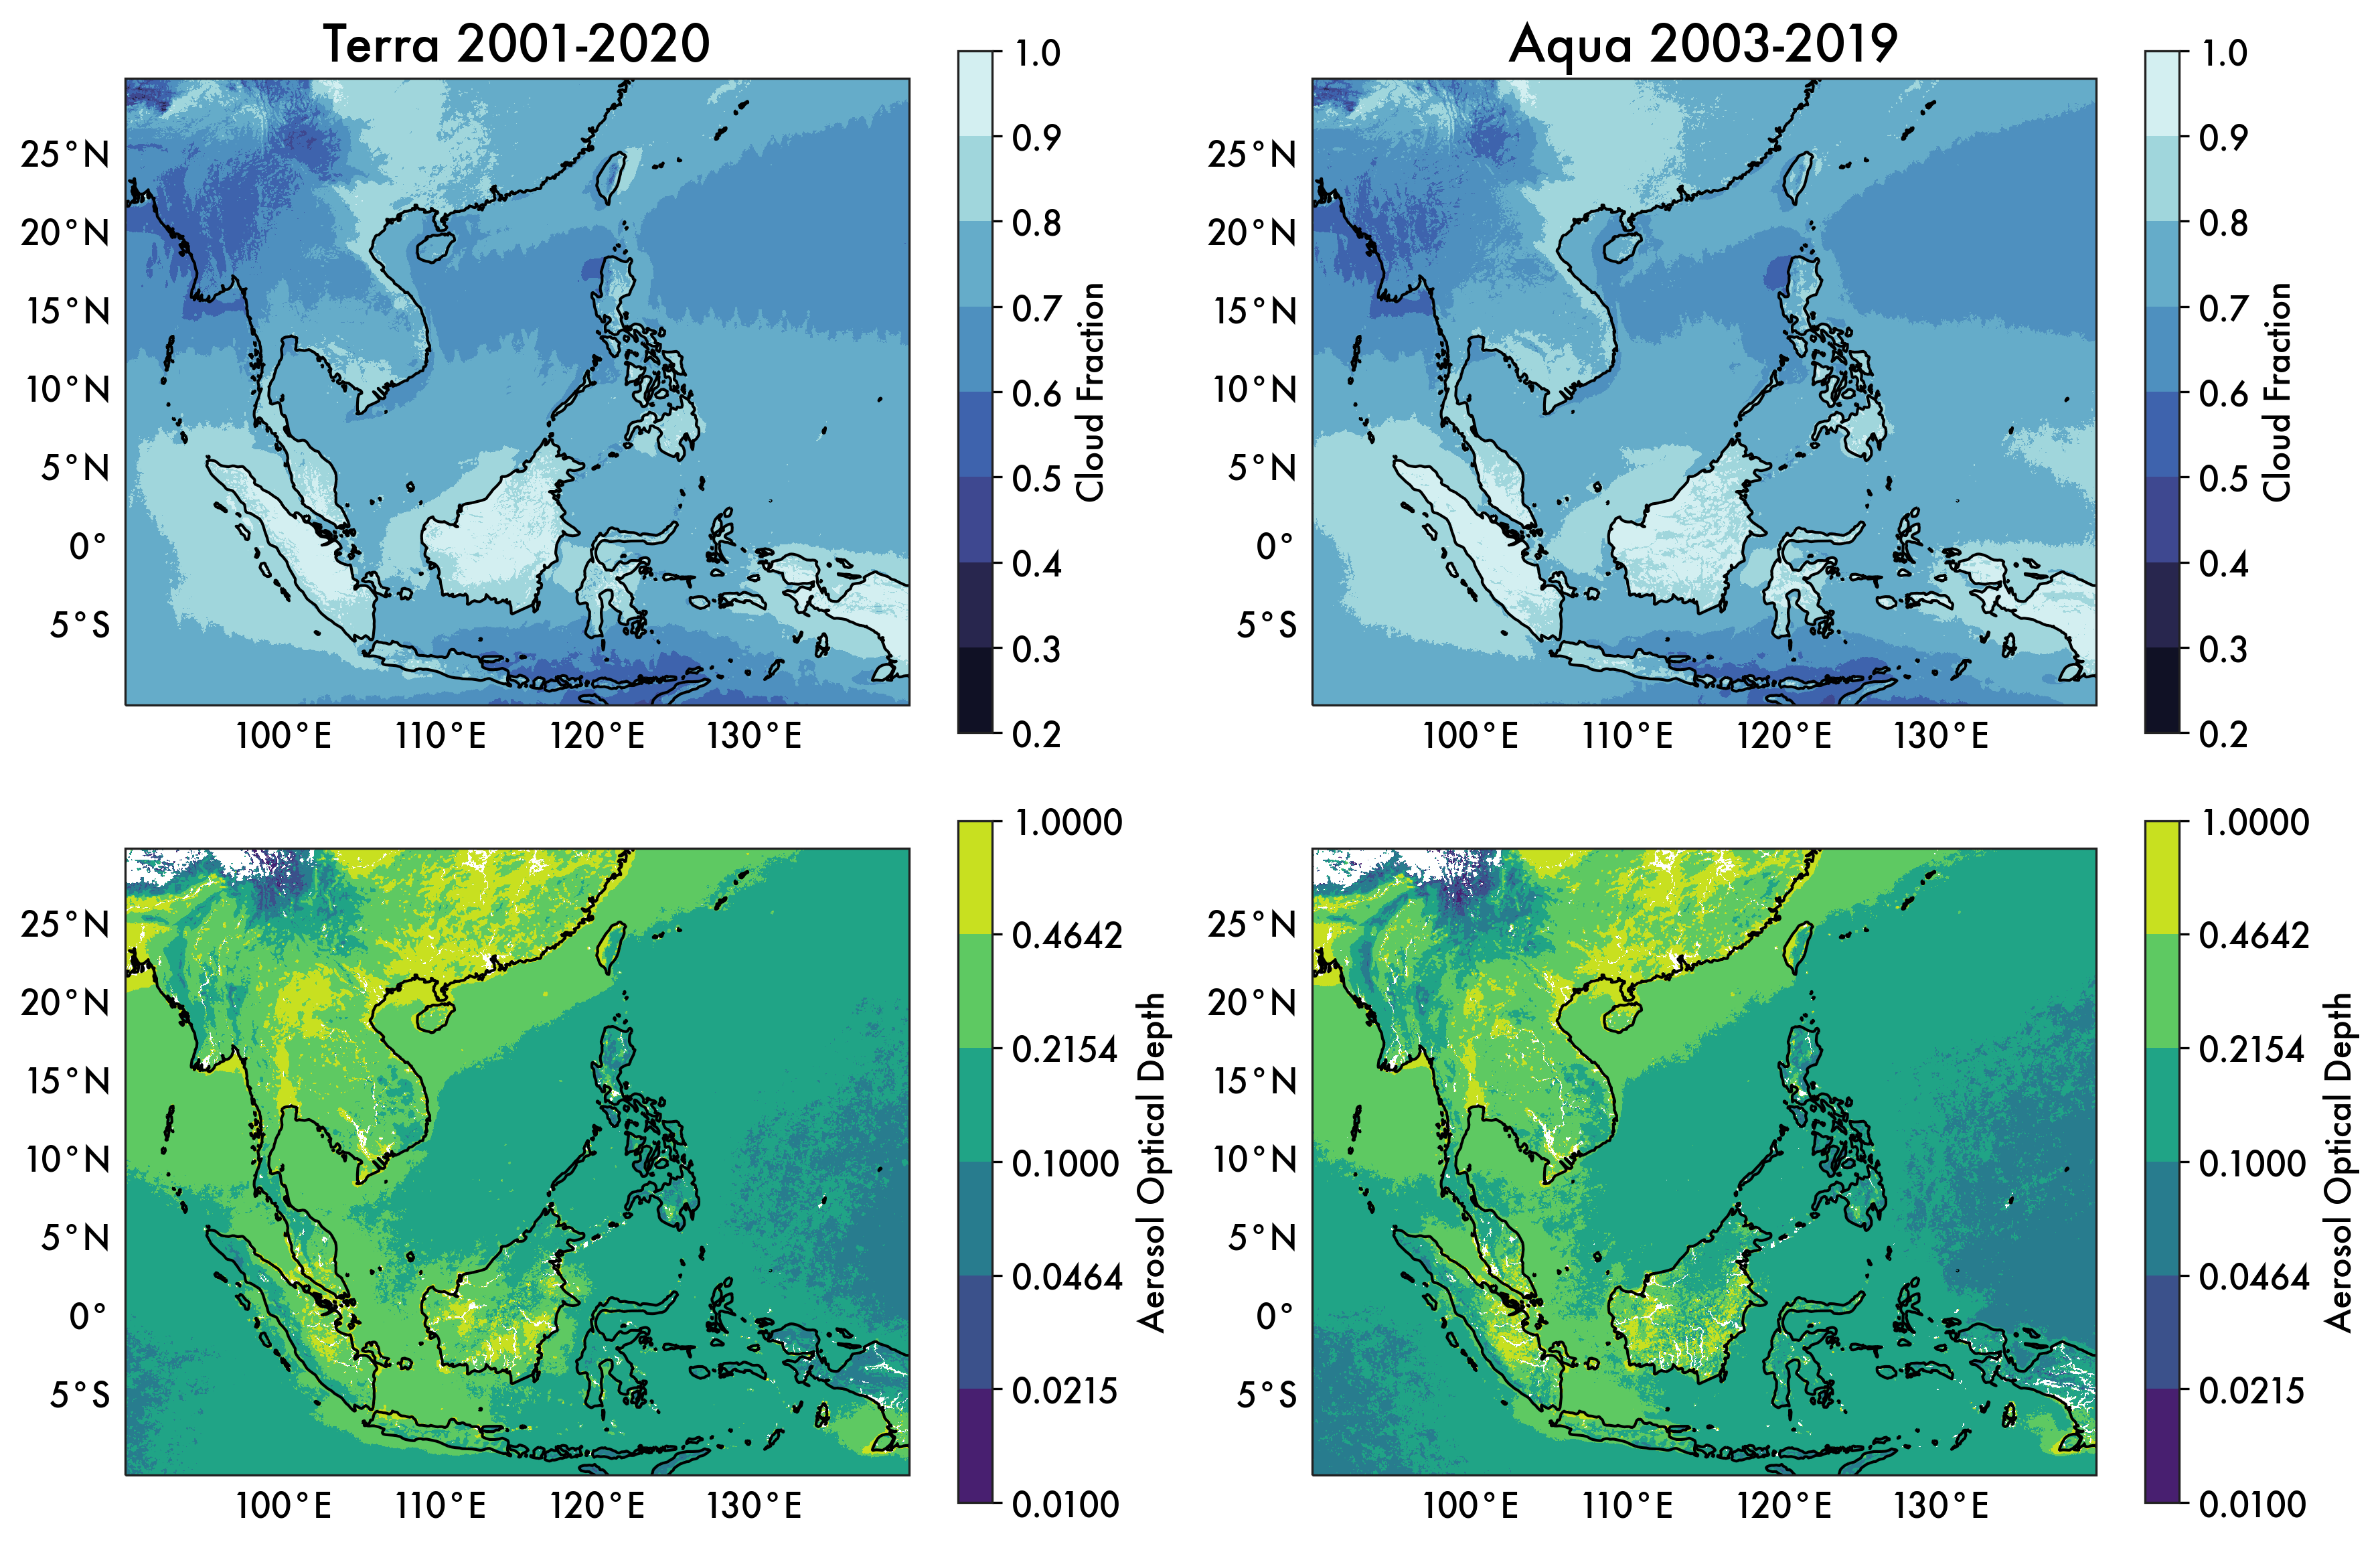

In [95]:
fig, axes = plt.subplots(2,2,
                       figsize=(12,8),
                       subplot_kw={'projection':ccrs.PlateCarree()})

for axs, var in zip(axes, ['cf','aod']):
    if var == 'cf':
        cmap = cloud
        label = 'Cloud Fraction'
        norm = None
        levels = np.linspace(0.2, 1, 9)
    else:
        cmap = 'viridis'
        label = 'Aerosol Optical Depth'
        norm = mcolors.LogNorm()
        levels = np.logspace(-2, 0, 7)
        
    for ax, ver in zip(axs, ['terra','aqua']):
        path = [f"/moonbow/gleung/satlcc/MODIS_{ver}_{var}/{p}" for p in os.listdir(f'/moonbow/gleung/satlcc/MODIS_{ver}_{var}/') if 'annual_ave' in p][0]

        df = pd.read_pickle(f"{path}")
        plot = df.reset_index().pivot(index='lat',columns='lon',values='mean')
        c = ax.contourf(plot.columns, 
                        plot.index,
                        plot.values,
                       levels = levels,
                        cmap = cmap,
                       norm = norm)
        plt.colorbar(c,ax=ax, label = label)

        ax.coastlines()
        add_latlon(ax)
    
axes[0,0].set_title("Terra 2001-2020",loc='center')
axes[0,1].set_title("Aqua 2003-2019",loc='center')      

plt.show()